In [119]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

![diagram](./assets/buckshot-roulette-diagram.png)

In [58]:
player_strategy = lambda bullets, fakes: "himself" if(bullets == fakes or fakes > bullets) else "shoot"
dealer_strategy = lambda bullets, fakes:  "himself" if np.random.randint(2) else "shoot"

In [81]:
def gun(bullets, fakes) -> bool:
    v = bullets + fakes
    r = np.random.randint(1, v+1)
    return r <= bullets
    

def play(strategies:dict, players:list, total_bullets:int, total_fakes:int, debug:bool=False) -> pd.DataFrame:
    lives = {
        "player":0,
        "dealer":0
    }

    actual_player = players[0]
    oponent = players[1]
    rounds = 0
    while(total_bullets):
        player = strategies[actual_player]
        action = player(total_bullets, total_fakes)
        shot = gun(total_bullets, total_fakes)

        if(debug):
            print(f"playing: {actual_player}")
            print(f"oponent: {oponent}")
            print(f"action: {action}")
            print(f"shot: {shot}")
        

        if(action == "shoot" and shot):
            lives[oponent] -=1
            total_bullets -=1
            actual_player = players[0]
            oponent = players[1]

        elif(action == "shoot" and not shot):
            total_fakes -=1
            actual_player,oponent = oponent,actual_player

        elif(action == "himself" and shot):
            lives[actual_player] -=1
            total_bullets -=1
            actual_player = players[0]
            oponent = players[1]

        else:
            total_fakes -=1            

        if(debug):
            print(lives, end="\n\n")

        rounds += 1

    if(lives['player'] > lives['dealer']):
        return 'player', rounds
    elif(lives['dealer'] > lives['player']):
        return 'dealer', rounds
    else:
        return 'draw', rounds


In [82]:
play({"player":player_strategy, "dealer":dealer_strategy}, ("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)

playing: player
oponent: dealer
action: himself
shot: False
{'player': 0, 'dealer': 0}

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



('dealer', 2)

In [94]:
def get_experiment_results(n:int, players_strategies:dict, players:list, total_bullets:int, total_fakes:int):
    df = pd.DataFrame(columns=("total_player", "total_dealer"))
    n_rounds = pd.Series()

    j = 1000
    for i in range(n):
        results = {"player":0, "dealer":0}
        for _ in range(j):
            result, rounds = play(players_strategies, players, total_bullets, total_fakes)
            results[result]+=1
            n_rounds.loc[j*i + j] = rounds
        df.loc[i] = {"total_player":results['player'], "total_dealer":results['dealer']}
    return df, n_rounds

1    337
3    334
2    329
Name: count, dtype: int64


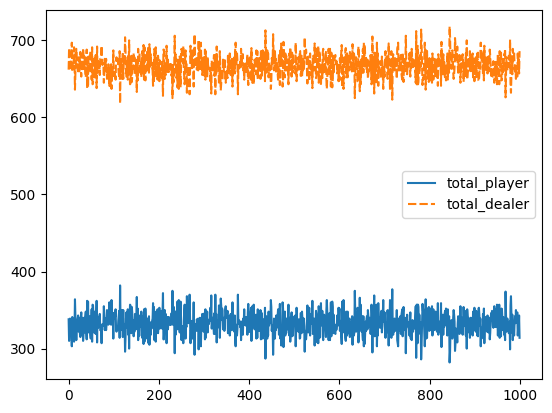

In [125]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

3    351
2    334
1    315
Name: count, dtype: int64


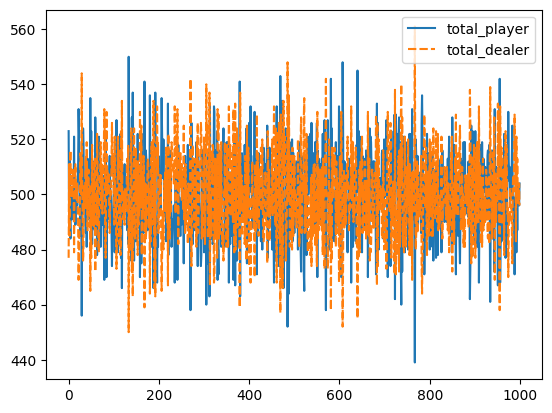

In [126]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":dealer_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

2    349
3    330
1    321
Name: count, dtype: int64


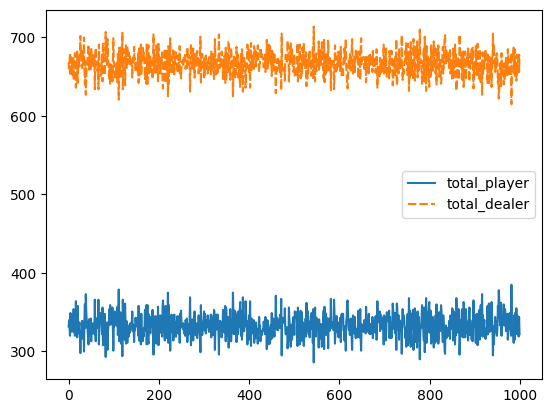

In [127]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_strategy, "dealer":player_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [75]:
def player_start_himself_strategy(bullets, fakes):
    if(bullets == 1 and fakes == 2):
        return 'himself'

    elif(bullets == fakes):
        return 'shoot' if np.random.randint(2) else "himself"

    return 'shoot'

2    366
1    331
3    303
Name: count, dtype: int64


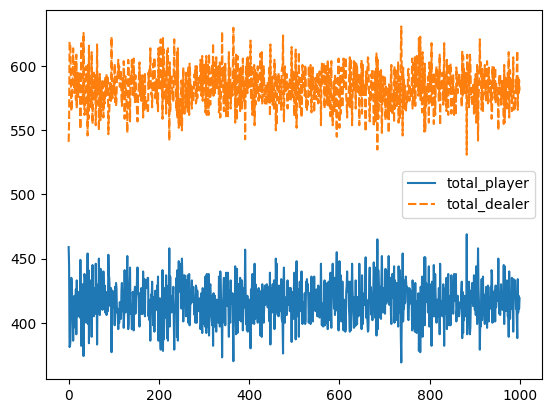

In [128]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_start_himself_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [79]:
def player_optimal_strategy(bullets, fakes):
    if(bullets == 1 and fakes == 2):
        return 'shoot'

    elif(bullets == fakes):
        return 'shoot' if np.random.randint(2) else "himself"

    return 'shoot'

2    1056
1    1001
3     943
Name: count, dtype: int64


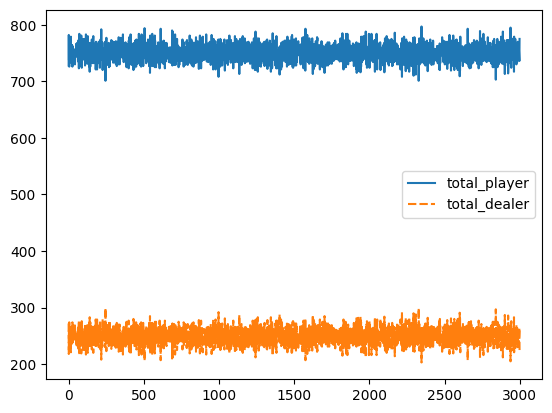

In [130]:
df,rounds = get_experiment_results(n=3000, players_strategies={"player":player_optimal_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [135]:
df,rounds = play({"player":player_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the first strategy, there're some possible ways to finish the game

# player shoot himself (first round)
# dealer shoot himself (second round)
# dealer shoot the player (second round)
# player shoot (third round)

# so the player loses most part of the time

playing: player
oponent: dealer
action: himself
shot: False
{'player': 0, 'dealer': 0}

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



2

In [148]:
df,rounds = play({"player":player_start_himself_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the second strategy, there're some possible ways to finish the game

# player shoot himself (first round)
# player shoot himself (second round)
# player shoot the dealer (second round)
# dealer shoot the player (third round)
# dealer shoot himself (third round)

# so the player loses most part of the time

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



1

In [155]:
df,rounds = play({"player":player_optimal_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the third strategy, there're some possible ways to finish the game

# player shoot the dealer (first round)
# dealer shoot himself (second round)
# dealer shoot the player (second round)
# dealer shoot himself (third round)
# dealer shoot the player (third round)
# player shoot the dealer(third round)

# so the dealer loses most part of the time
# as in the first play the player chooses to shoot the dealer, he has more chances to live, once he's removed one of the dying chances

playing: player
oponent: dealer
action: shoot
shot: True
{'player': 0, 'dealer': -1}



1

---

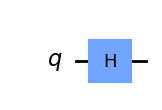

In [33]:
player = QuantumCircuit(1, name="Player")
player.h(0)
player.draw('mpl', style="clifford")

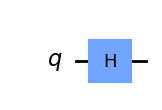

In [34]:
dealer = QuantumCircuit(1, name="Dealer")
dealer.h(0)
player.draw('mpl', style="clifford")

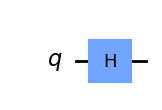

In [60]:
gun = QuantumCircuit(1, name="shoot")
gun.h(0)
gun.draw('mpl', style='clifford')

In [61]:
player_gate = player.to_gate()
player_controlled_gate = player.to_gate().control(1)
dealer_controlled_gate = dealer.to_gate().control(1)
gun_controlled_gate = gun.to_gate().control(1)

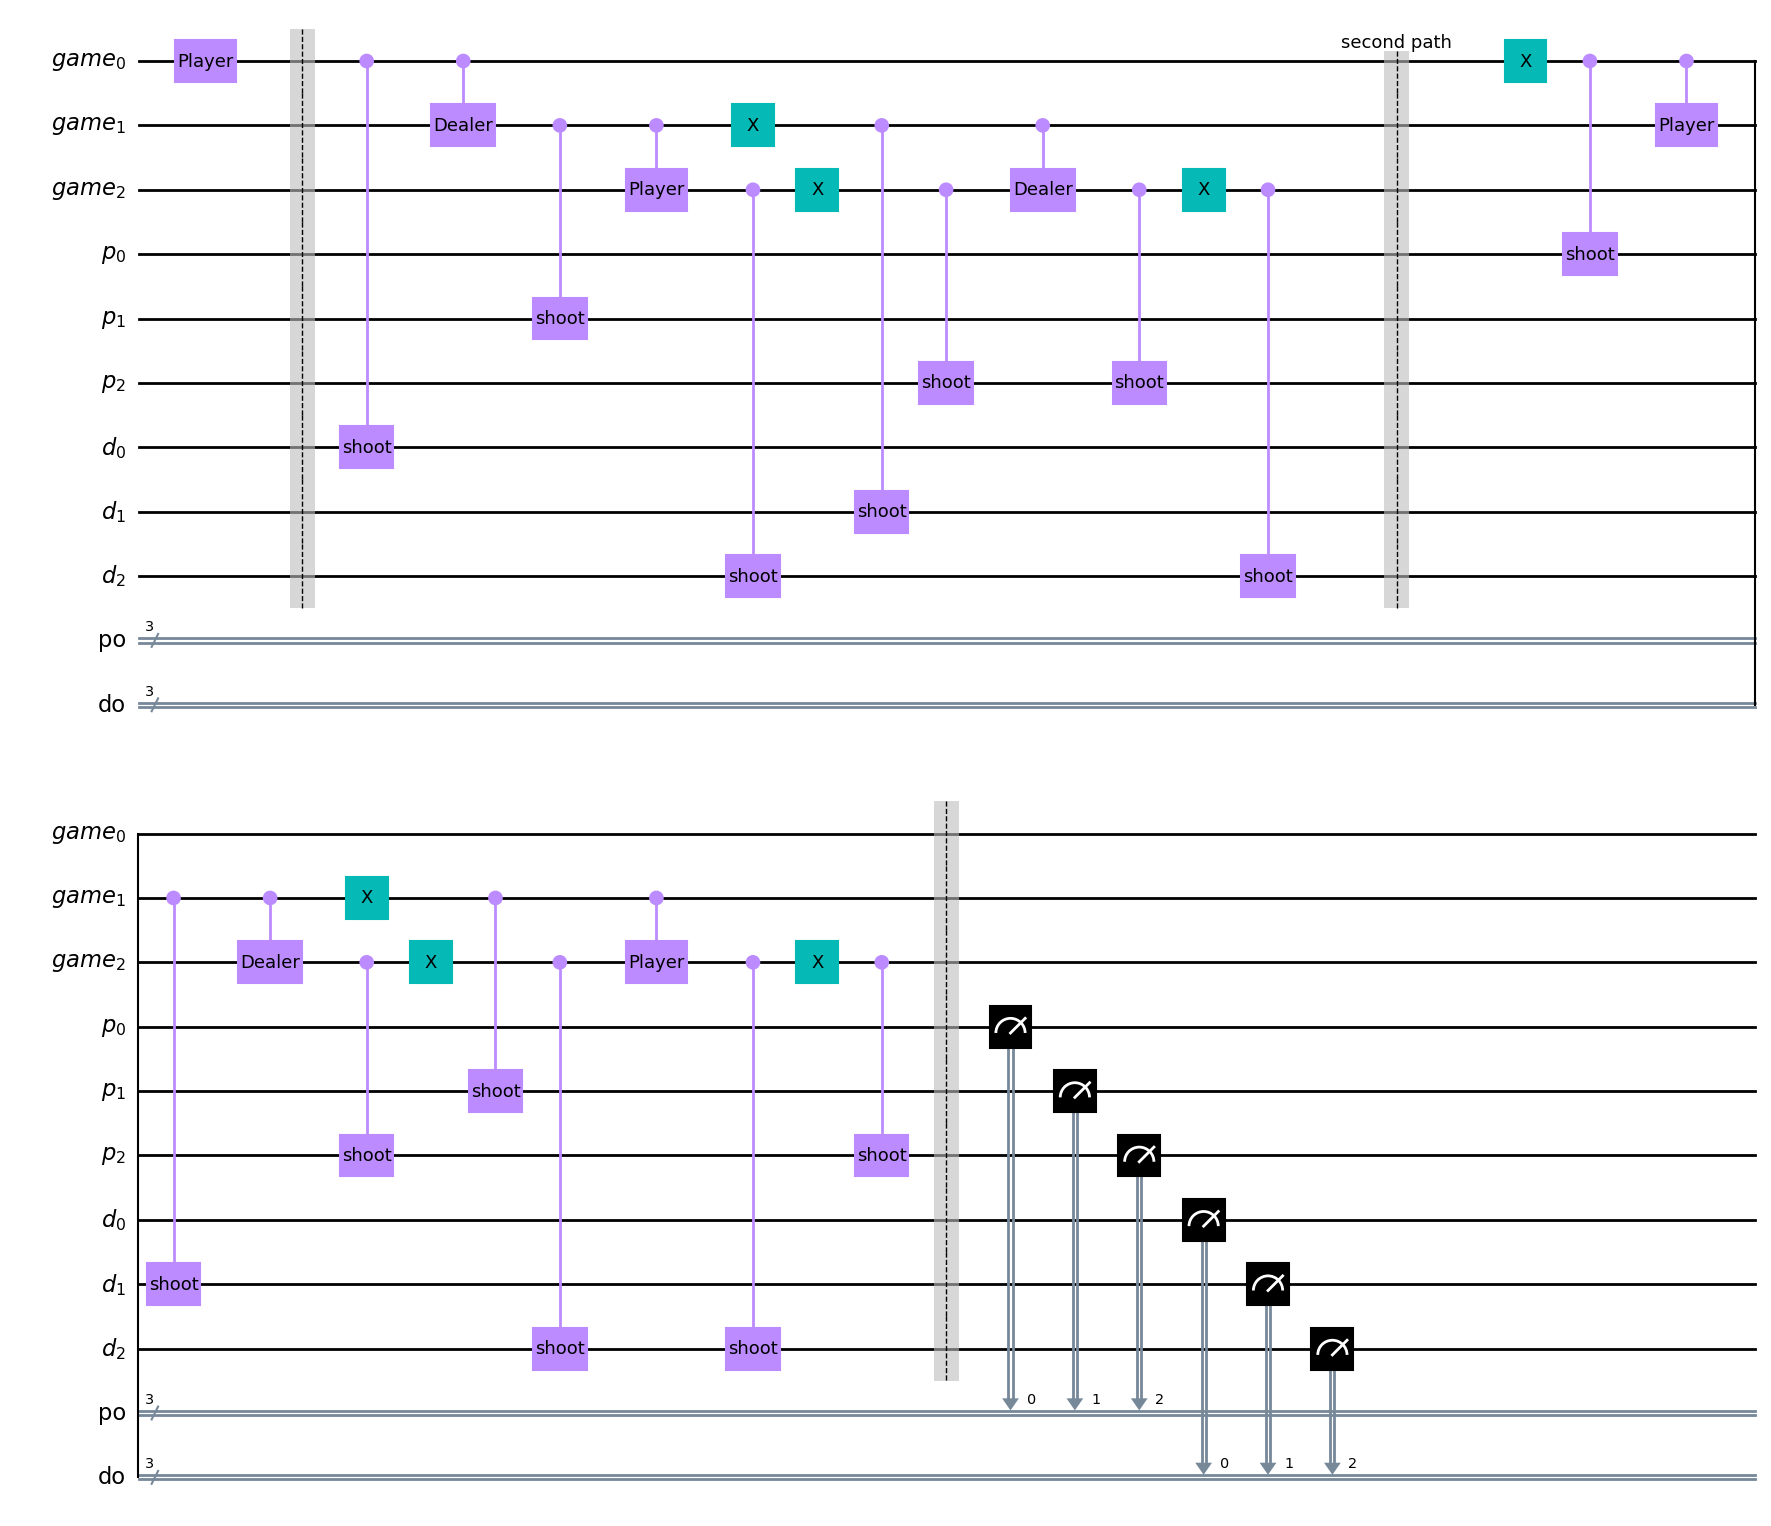

In [118]:
player_life  = QuantumRegister(3, name="p") 
dealer_life  = QuantumRegister(3, name="d")
game = QuantumRegister(3, name="game")
player_life_out = ClassicalRegister(3, name="po")
dealer_life_out = ClassicalRegister(3, name="do")

qc = QuantumCircuit(game, player_life, dealer_life, player_life_out, dealer_life_out)

qc.append(player, [game[0]])
qc.barrier()
qc.append(gun_controlled_gate, [game[0], dealer_life[0]])
qc.append(dealer_controlled_gate, [game[0], game[1]])
qc.append(gun_controlled_gate, [game[1], player_life[1]])
qc.append(player_controlled_gate, [game[1], game[2]])
qc.append(gun_controlled_gate, [game[2], dealer_life[2]])

qc.x(game[2])
qc.append(gun_controlled_gate, [game[2], player_life[2]])

qc.x(game[1])
qc.append(gun_controlled_gate, [game[1], dealer_life[1]])

qc.append(dealer_controlled_gate, [game[1], game[2]])
qc.append(gun_controlled_gate, [game[2], player_life[2]])
qc.x(game[2])
qc.append(gun_controlled_gate, [game[2], dealer_life[2]])


qc.barrier(label="second path")

qc.x(game[0])
qc.append(gun_controlled_gate, [game[0], player_life[0]])
qc.append(player_controlled_gate, [game[0], game[1]])
qc.append(gun_controlled_gate, [game[1], dealer_life[1]])

qc.append(dealer_controlled_gate, [game[1], game[2]])
qc.append(gun_controlled_gate, [game[2], player_life[2]])
qc.x(game[2])
qc.append(gun_controlled_gate, [game[2], dealer_life[2]])

qc.x(game[1])
qc.append(gun_controlled_gate, [game[1], player_life[1]])
qc.append(player_controlled_gate, [game[1], game[2]])
qc.append(gun_controlled_gate, [game[2], dealer_life[2]])
qc.x(game[2])
qc.append(gun_controlled_gate, [game[2], player_life[2]])

qc.barrier()
qc.measure(player_life, player_life_out)
qc.measure(dealer_life, dealer_life_out)

qc.draw('mpl', style="clifford")

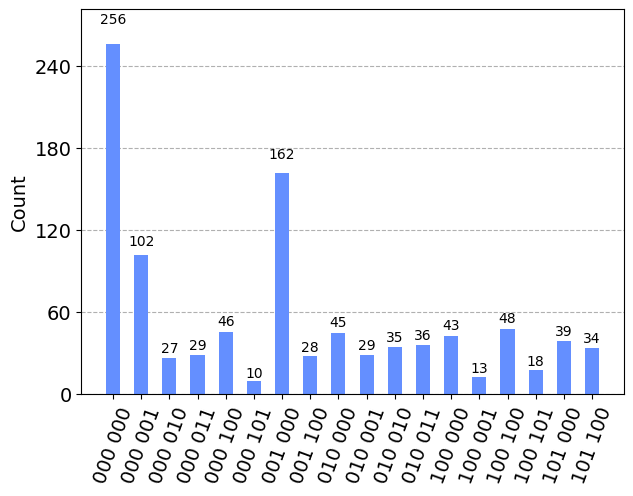

In [120]:
sim = AerSimulator()
transpiled_qc = transpile(qc, sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
plot_histogram(result)